In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import pretrainedmodels
import torch
%matplotlib inline 

In [3]:
scenes = ['FloorPlan1']
data_dir = '/home/chenjunting/Documents/ai2thor_datasets/thor_offline_data_with_images'

In [4]:
# play ground 
scene = scenes[0]
images = h5py.File('{}/{}/images.hdf5'.format(data_dir, scene), 'r')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
def transform_visualize(input_image, im_size=224):

    all_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(im_size),
        transforms.CenterCrop(im_size),
    ])
    transformed_image = all_transforms(input_image)
    return transformed_image

In [6]:
def resnet_input_transform(input_image, im_size=224):

    all_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(im_size),
        transforms.CenterCrop(im_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    transformed_image = all_transforms(input_image)
    return transformed_image

In [10]:
def extract_resnet18_features(scenes, data_dir, method):
    
    resnet18 = pretrainedmodels.__dict__['resnet18'](num_classes=1000, pretrained='imagenet')
    if torch.cuda.is_available():
        resnet18.cuda()
    
    for scene in scenes:
        images = h5py.File('{}/{}/images.hdf5'.format(data_dir, scene), 'r')
        features = h5py.File('{}/{}/{}.hdf5'.format(data_dir, scene, method), 'w')

        for k in images:
            frame = resnet_input_transform(images[k][:], 224)
            frame = torch.Tensor(frame)
            if torch.cuda.is_available():
                frame = frame.cuda()
            frame = frame.unsqueeze(0)
            
            v = resnet18.features(frame)
            v = v.view(512, 7, 7)

            v = v.cpu().detach().numpy()
            features.create_dataset(k, data=v)

        images.close()
        features.close()

In [11]:
extract_resnet18_features(scenes, data_dir, 'resnet18_featuremap')

-0.25|-1.25|0|0


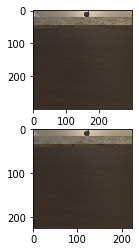

In [9]:
for k in images:
    print(k)
    image = images[k][:]
    plt.figure(1)
    plt.subplot(211)
    plt.imshow(image)
    frame = np.array(transform_visualize(image))
    plt.subplot(212)
    plt.imshow(frame)
    break 